In [1]:
import numpy as np
import torch
from torch import distributions
from torch.distributions import constraints, transform_to
import torch.nn as nn
import tqdm
import gpytorch
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import train_test_split
from gpytorch.models import ApproximateGP
from gpytorch.variational.nearest_neighbor_variational_strategy import NNVariationalStrategy

%matplotlib inline

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Implement knn

In [3]:
# Define parameters for the sine wave
frequency = 0.5  # Frequency of the sine wave (in cycles per unit)
amplitude = 5.0  # Amplitude of the sine wave
num_points = 1000  # Number of points to sample

# Generate x-coordinates (time points)
x = np.linspace(0, 2 * np.pi, num_points)

# Calculate y-coordinates (sine values)
y = amplitude * np.sin(2 * np.pi * frequency * x)

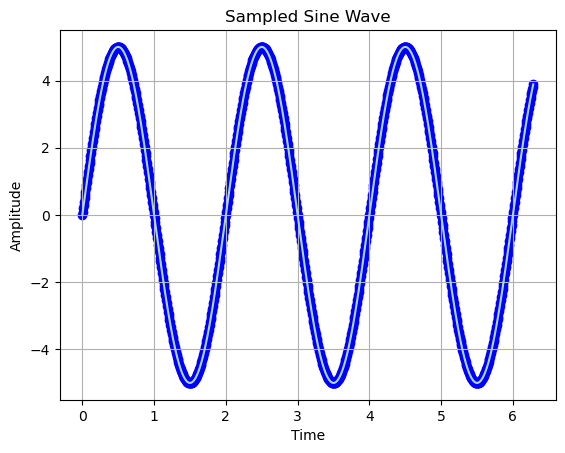

In [4]:
# Plot the sine wave
plt.plot(x,y, color="lightblue")
plt.scatter(x, y, color="blue")
plt.title("Sampled Sine Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [14]:
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance += (row1[i] - row2[i])**2
    return math.sqrt(distance)

In [15]:
def get_neighbors(train, test, k=3):
    distances = []
    for row in train:
        dist = euclidean_distance([row], test)
        distances.append((row, dist))
        distances.sort(key=lambda tup: tup[1])
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

In [16]:
def predict(train, test, values, k=3):
    neighbors = get_neighbors(train, [test])
    
    # find corresponding output values for each input value in neighbors
    outputs = []
    train_list = list(train)
    for n in neighbors:
        index = train_list.index(n)
        outputs.append(values[index])
    return sum(outputs)/len(outputs) # average
        

In [17]:
def k_nearest_neighbors(train, test, values, k=3):
    predictions = []
    for val in test:
        output = predict(train, val, values)
        predictions.append(output)
    return predictions  

In [18]:
# Split the data and labels into train and test sets
split_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1 - split_ratio, random_state=42)

In [19]:
trial = k_nearest_neighbors(X_train, X_test, y_train)

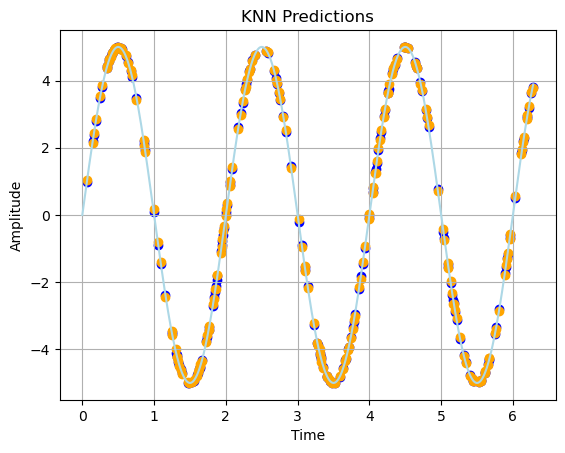

In [22]:
plt.plot(x,y, color="lightblue")
plt.scatter(X_test, y_test, color="blue")
plt.scatter(X_test, trial, color="orange") # predictions
plt.title("KNN Predictions")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## Implement VNNGP using GpyTorch

In [23]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points, likelihood, k=256, training_batch_size=256):

        m, d = inducing_points.shape
        self.m = m
        self.k = k

        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(m)

        if torch.cuda.is_available():
            inducing_points = inducing_points.cuda()

        variational_strategy = NNVariationalStrategy(self, inducing_points, variational_distribution, k=k,
                                                     training_batch_size=training_batch_size)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=d)

        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, prior=False, **kwargs):
        if x is not None:
            if x.dim() == 1:
                x = x.unsqueeze(-1)
        return self.variational_strategy(x=x, prior=False, **kwargs)

In [24]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [37]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

/var/folders/dv/w3pzlt_11hdcpw6gskd45b_80000gn/T/ipykernel_9240/3313886821.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)
/var/folders/dv/w3pzlt_11hdcpw6gskd45b_80000gn/T/ipykernel_9240/3313886821.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test)


In [26]:
k = 256
training_batch_size = 64
# Note: one should use full training set as inducing points!
model = GPModel(inducing_points=X_train[:, np.newaxis], likelihood=likelihood, k=k, training_batch_size=training_batch_size)

In [38]:
num_epochs = 500
num_batches = model.variational_strategy._total_training_batches

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))


epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for epoch in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(range(num_batches), desc="Minibatch", leave=False)

    for i in minibatch_iter:
        optimizer.zero_grad()
        output = model(x=None)
        # Obtain the indices for mini-batch data
        current_training_indices = model.variational_strategy.current_training_indices
        
        # Obtain the y_batch using indices. It is important to keep the same order of train_x and train_y
        y_batch = y_train[...,current_training_indices]
        if torch.cuda.is_available():
            y_batch = y_batch.cuda()
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
from torch.utils.data import TensorDataset, DataLoader

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [40]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
test_mse = 0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])

        diff = torch.pow(preds.mean - y_batch, 2)
        diff = diff.sum(dim=-1) / X_test.size(0) # sum over bsz and scaling
        diff = diff.mean() # average over likelihood_nsamples
        test_mse += diff
means = means[1:]
test_rmse = test_mse.sqrt().item()

In [41]:
print(test_rmse)

3.37666684047665


In [42]:
print(loss)

tensor(2.6220, dtype=torch.float64, grad_fn=<NegBackward0>)


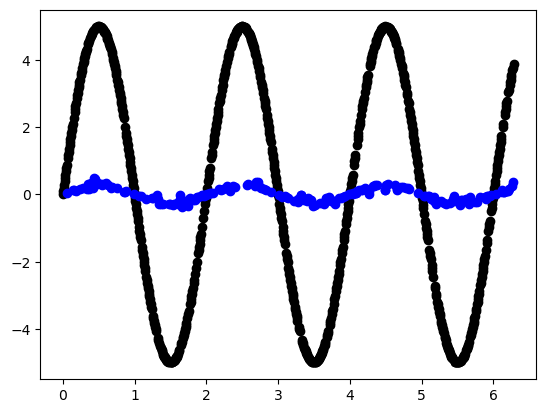

In [46]:
# Get upper and lower confidence bounds
#lower, upper = preds.confidence_region()

X_train = [float(i) for i in X_train]
y_train = [float(i) for i in y_train]

# Plot training data
plt.scatter(X_train, y_train, color="black")
#plt.plot(X_train, means, color="black")

# Plot predictive means as blue line
plt.scatter(X_test.numpy(), means.numpy(), color="blue")